In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
import time

In [2]:
data=yf.download('^HSI','2019-01-01','2022-01-01')
data.drop('Volume',1,inplace=True)
data

[*********************100%***********************]  1 of 1 completed


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26858/178164014.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('Volume',1,inplace=True)


,Open,High,Low,Close,Adj Close
Date,,,,,
2019-01-02,25824.439453,25824.439453,25055.269531,25130.349609,25130.349609
2019-01-03,25077.679688,25262.210938,24896.869141,25064.359375,25064.359375
2019-01-04,24946.119141,25626.029297,24924.730469,25626.029297,25626.029297
2019-01-07,26015.839844,26043.640625,25753.460938,25835.699219,25835.699219
2019-01-08,25852.500000,25960.890625,25688.500000,25875.449219,25875.449219
...,...,...,...,...,...
2021-12-24,23375.990234,23383.189453,23186.570312,23223.759766,23223.759766
2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547
2021-12-29,23253.980469,23253.980469,23008.279297,23086.539062,23086.539062


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
Target=data['Prediction']

In [4]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
start_time = time.time()
#k_features=10 (It will get top 10 features best suited for prediction)
#forward=False (Backward feature selection model)
#verbose=2 (It will show details output as shown below.)
#cv=5 (Kfold cross valiation: it will split the training set in 5 set and 4 will be using for training the model and 1 will using as validation)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
backwardModel=sfs(RandomForestRegressor(),k_features=10,forward=False,verbose=2,cv=5,n_jobs=-1,scoring='r2')
#We will convert our training data into numpy array. If we will not convert it, model is not able to read some of the column names.
backwardModel.fit(np.array(data.drop('Prediction',1)),Target.values)
print("SBS takes --- %s seconds ---" % (time.time() - start_time))

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26858/3127396979.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  backwardModel.fit(np.array(data.drop('Prediction',1)),Target.values)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    4.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    5.3s finished

[2022-04-12 14:56:04] Features: 17/10 -- score: 0.8986213212765002[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    3.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    4.4s finished

[2022-04-12 14:56:09] Features: 16/10 -- score: 0.8997994272875633[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | ela

SBS takes --- 26.060714960098267 seconds ---


[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.9s finished

[2022-04-12 14:56:24] Features: 10/10 -- score: 0.9027759661211627

In [5]:
data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=Target
data.dropna(inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26858/2880702731.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Prediction']=Target
/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26858/2880702731.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


,High,Adj Close,6day MA,RSI,%R5,%R10,MI6,EMA12,MACD,TR,Prediction
Date,,,,,,,,,,,
2021-12-23,23264.750000,23193.640625,23113.381836,40.642395,-33.829525,-69.282998,-227.119141,23394.847996,-434.724976,237.599609,23223.759766
2021-12-24,23383.189453,23223.759766,23071.425130,42.025599,-22.206564,-67.532078,-251.740234,23368.526730,-416.171190,196.619141,23280.560547
2021-12-28,23319.439453,23280.560547,23086.080078,44.853017,-15.713893,-46.602926,87.929688,23354.993471,-392.360940,219.958984,23086.539062
2021-12-29,23253.980469,23086.539062,23143.026693,37.554170,-73.532117,-61.009804,341.679688,23313.692793,-384.712333,272.281250,23112.009766
2021-12-30,23248.259766,23112.009766,23166.473307,39.072663,-69.011382,-48.099517,140.679688,23282.664635,-372.303797,258.019531,23397.669922


In [6]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [7]:
# data['Prediction']=data['Close'].shift(-1)
# data.dropna(inplace=True)
# data_val=data[-100:]
# data=data[:-100]
# data_val.tail()

In [8]:
X=sc.fit_transform(data.drop('Prediction',1))
#X=data.drop('Prediction',1).values
# Y = data["Prediction"].values.reshape(-1,1)
# Y = sc_y.fit_transform(data["Prediction"].values.reshape(-1,1))
Y=np.array(data["Prediction"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(485, 1, 10) (485,) (122, 1, 10) (122,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26858/759405757.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [9]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
#     kernel_regularizer=regularizers.l1(0.01)
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

2022-04-12 14:56:24.551132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-12 14:56:24.551277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.001)
training_start=time.time()
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
#     callbacks=[es]
)
print("LSTM Training takes --- %s seconds ---" % (time.time() - training_start))
y_pred = model_tech.predict(X_test)

Epoch 1/500


2022-04-12 14:56:25.006325: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-12 14:56:26.214712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 14:56:26.414602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 14:56:26.451965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 14:56:26.525801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 14:56:26.599292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 3s 32ms/step - loss: 698631680.0000 - val_loss: 767235392.0000
Epoch 2/500
 1/28 [>.............................] - ETA: 0s - loss: 829455616.0000

2022-04-12 14:56:27.349480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 14:56:27.431648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 14:56:27.456899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 10ms/step - loss: 698495552.0000 - val_loss: 766757568.0000
Epoch 3/500
28/28 [==============================] - 0s 10ms/step - loss: 697535168.0000 - val_loss: 764054976.0000
Epoch 4/500
28/28 [==============================] - 0s 10ms/step - loss: 694128448.0000 - val_loss: 758638720.0000
Epoch 5/500
28/28 [==============================] - 0s 11ms/step - loss: 688559104.0000 - val_loss: 752511360.0000
Epoch 6/500
28/28 [==============================] - 0s 10ms/step - loss: 682432064.0000 - val_loss: 746222144.0000
Epoch 7/500
28/28 [==============================] - 0s 11ms/step - loss: 676145984.0000 - val_loss: 739589696.0000
Epoch 8/500
28/28 [==============================] - 0s 12ms/step - loss: 669532480.0000 - val_loss: 732504960.0000
Epoch 9/500
28/28 [==============================] - 0s 11ms/step - loss: 662503040.0000 - val_loss: 724927360.0000
Epoch 10/500
28/28 [==============================] - 0s 12ms/step - loss: 655026880

Epoch 144/500
28/28 [==============================] - 0s 10ms/step - loss: 805769.0625 - val_loss: 1390696.5000
Epoch 145/500
28/28 [==============================] - 0s 10ms/step - loss: 760735.2500 - val_loss: 1319364.7500
Epoch 146/500
28/28 [==============================] - 0s 10ms/step - loss: 720519.6250 - val_loss: 1253200.0000
Epoch 147/500
28/28 [==============================] - 0s 10ms/step - loss: 682850.7500 - val_loss: 1190037.8750
Epoch 148/500
28/28 [==============================] - 0s 10ms/step - loss: 648353.0625 - val_loss: 1130951.2500
Epoch 149/500
28/28 [==============================] - 0s 10ms/step - loss: 616307.3125 - val_loss: 1074731.3750
Epoch 150/500
28/28 [==============================] - 0s 10ms/step - loss: 586661.6250 - val_loss: 1021733.6250
Epoch 151/500
28/28 [==============================] - 0s 11ms/step - loss: 559131.5625 - val_loss: 971499.0625
Epoch 152/500
28/28 [==============================] - 0s 10ms/step - loss: 533573.3750 - val_los

28/28 [==============================] - 0s 10ms/step - loss: 138229.0781 - val_loss: 142009.6250
Epoch 218/500
28/28 [==============================] - 0s 10ms/step - loss: 137157.0312 - val_loss: 140494.4688
Epoch 219/500
28/28 [==============================] - 0s 10ms/step - loss: 136118.8594 - val_loss: 139054.2188
Epoch 220/500
28/28 [==============================] - 0s 10ms/step - loss: 135112.9688 - val_loss: 137686.7969
Epoch 221/500
28/28 [==============================] - 0s 10ms/step - loss: 134138.7812 - val_loss: 136387.5469
Epoch 222/500
28/28 [==============================] - 0s 11ms/step - loss: 133194.4531 - val_loss: 135154.3125
Epoch 223/500
28/28 [==============================] - 0s 10ms/step - loss: 132278.8281 - val_loss: 133985.0312
Epoch 224/500
28/28 [==============================] - 0s 11ms/step - loss: 131390.9219 - val_loss: 132876.2812
Epoch 225/500
28/28 [==============================] - 0s 12ms/step - loss: 130529.8672 - val_loss: 131824.0312
Epoch 

28/28 [==============================] - 0s 10ms/step - loss: 99642.9062 - val_loss: 115472.5703
Epoch 364/500
28/28 [==============================] - 0s 10ms/step - loss: 99593.4297 - val_loss: 115501.7188
Epoch 365/500
28/28 [==============================] - 0s 10ms/step - loss: 99544.0391 - val_loss: 115531.6328
Epoch 366/500
28/28 [==============================] - 0s 10ms/step - loss: 99494.8516 - val_loss: 115561.7969
Epoch 367/500
28/28 [==============================] - 0s 10ms/step - loss: 99445.5312 - val_loss: 115592.7500
Epoch 368/500
28/28 [==============================] - 0s 10ms/step - loss: 99396.1406 - val_loss: 115624.1641
Epoch 369/500
28/28 [==============================] - 0s 10ms/step - loss: 99346.6719 - val_loss: 115655.9375
Epoch 370/500
28/28 [==============================] - 0s 12ms/step - loss: 99297.3047 - val_loss: 115688.7500
Epoch 371/500
28/28 [==============================] - 0s 10ms/step - loss: 99247.8828 - val_loss: 115721.7656
Epoch 372/500
2

Epoch 437/500
28/28 [==============================] - 0s 10ms/step - loss: 94692.1406 - val_loss: 117861.9141
Epoch 438/500
28/28 [==============================] - 0s 10ms/step - loss: 94591.4609 - val_loss: 117867.6641
Epoch 439/500
28/28 [==============================] - 0s 10ms/step - loss: 94489.7734 - val_loss: 117872.0000
Epoch 440/500
28/28 [==============================] - 0s 11ms/step - loss: 94387.1406 - val_loss: 117875.5000
Epoch 441/500
28/28 [==============================] - 0s 12ms/step - loss: 94283.5000 - val_loss: 117876.2500
Epoch 442/500
28/28 [==============================] - 0s 10ms/step - loss: 94178.7578 - val_loss: 117875.4141
Epoch 443/500
28/28 [==============================] - 0s 10ms/step - loss: 94073.0859 - val_loss: 117871.9688
Epoch 444/500
28/28 [==============================] - 0s 10ms/step - loss: 93966.3984 - val_loss: 117866.7734
Epoch 445/500
28/28 [==============================] - 0s 10ms/step - loss: 93858.7031 - val_loss: 117859.2109
E

2022-04-12 14:58:52.034841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 14:58:52.106376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 14:58:52.143243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


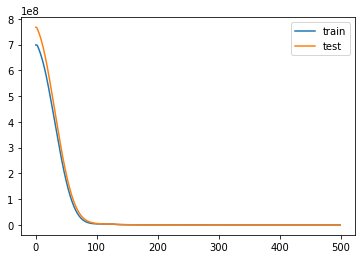

In [11]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

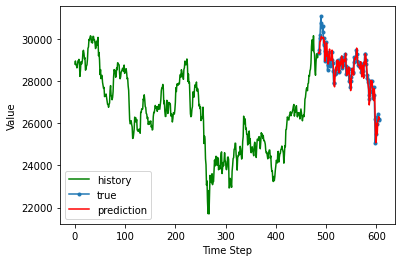

In [12]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
# plt.plot(np.arange(0, len(y_train)), sc_y.inverse_transform(y_train), 'g', label="history")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_test), marker='.', label="true")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

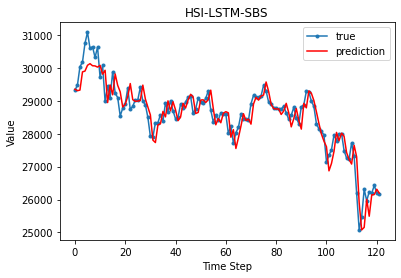

In [23]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM-SBS')
plt.legend()
plt.show();

In [24]:
r2_score(y_test,y_pred)

0.8518484481389161

In [25]:
mean_absolute_percentage_error(y_test,y_pred)

0.010985338068217476

In [26]:
mean_squared_error(y_test,y_pred,squared=False)

401.91851353655005

In [17]:
x_val=data_val.drop('Prediction',1).values
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_26858/2175021245.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1).values
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


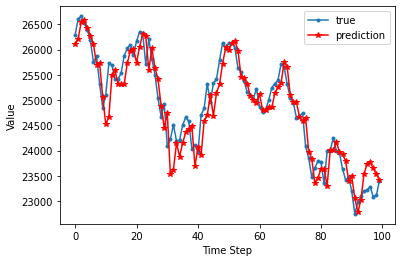

In [18]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [19]:
r2_score(y_val,y_val_pred)

0.8783420311409339

In [20]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.011199018656807322

In [21]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

350.38077222339325